<b><span style="font-size:150%">Work in progress</span></b>

version October 1st, 2018

# Introduction

In this notebook we'll study **decision trees**. Why?
1. They form the basis for some of the most powerful methods in all of machine learning
2. They produce highly interpretable models, which is useful in contexts where you need high explainability (law, finance, medicine, and much more).

**Overview:**


- We'll first introduce decision trees: what they are and how they can be trained (or "grown") using the CART algorithm.



- We'll also see that they can produce very complicated decision boundaries when used for classification, which makes them capable of fitting very complicated training data sets. 



- We'll see how decision trees can be used for both classification and regression. 



- We'll also see that they often tend to overfit, which will motivate our work to extend them to models with less variance through ensembling. This will result in the **random forests** models, discussed in the next notebook. 

See also Gerons notebook here: https://github.com/ageron/handson-ml/blob/master/06_decision_trees.ipynb

# Setup

We need our standard framework:

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Decision trees

From a set of labelled data a classification tree learns a set of if-else questions asked about the features and used to predict the labels. 

To be concrete, let's use the diabetes data set studied in previous notebooks. We load it as before:

In [4]:
datadir = Path("./data")
datadir.mkdir(exist_ok=True)

In [5]:
import urllib.request
url = 'https://assets.datacamp.com/production/course_1939/datasets/diabetes.csv'
urllib.request.urlretrieve(url, 'data/diabetes.csv')

('data/diabetes.csv', <http.client.HTTPMessage at 0x7f57d52e9da0>)

In [6]:
diabetes = pd.read_csv(datadir/'diabetes.csv')

It has 8 features and a binary label (diabetes vs. not diabetes):

In [7]:
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's restrict ourselves to two features for easier visualization:

In [8]:
data = diabetes[['glucose', 'bmi', 'diabetes']]

Here's a scatter plot of the data we have, with glucose levels plotted agains bmi, and the dots colored by whether the person has diabets or not:

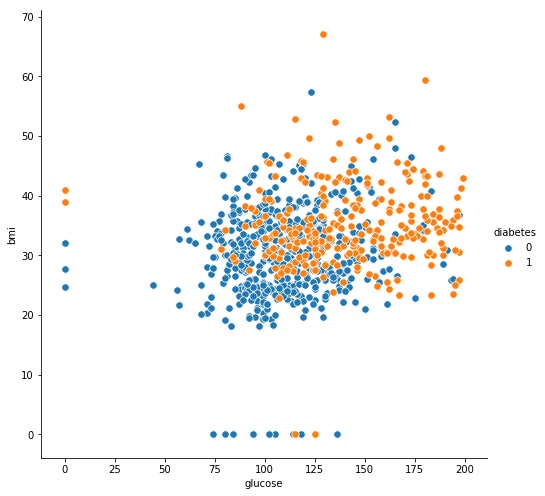

In [9]:
sns.pairplot(x_vars = 'glucose', y_vars = 'bmi', data=data, hue='diabetes', 
             height=7, plot_kws={"s": 55} # Size of figure and markers
            )
plt.show()

We notice that diabetes instances tend to have both higher blood glucose levels and also higher body mass index.

To decide whether a person has diabetes we could therefore make a set of rules saying things like

- "If your glucose level is above 100 *and* your BMI is above 25, then predict diabetes."
- "If glucose below 150 _and_ BMI above 40, then predict diabetes"
- and so on...

Such a set of rules is exactly a **decision tree**.

Let's use scikit-learn to make the rules and the tree for us:

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=seed)

In [12]:
X=data[['glucose', 'bmi']] # The features
y=data['diabetes'] # The labels

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

In [15]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

...and plot it:

> **Note: you need graphviz https://graphviz.gitlab.io/download/ on your computer for the below to work**. Also, update your dat158 environment if you haven't done so in a while (run `conda env update` inside the DAT158ML folder).

In [16]:
from graphviz import Source
from IPython.display import display
from IPython.display import SVG

In [17]:
from sklearn.tree import export_graphviz

In [18]:
graph = Source(export_graphviz(tree_clf, out_file=None, feature_names=X.columns, 
                               class_names=['not diabetes','diabetes'], filled = True, rounded=True))

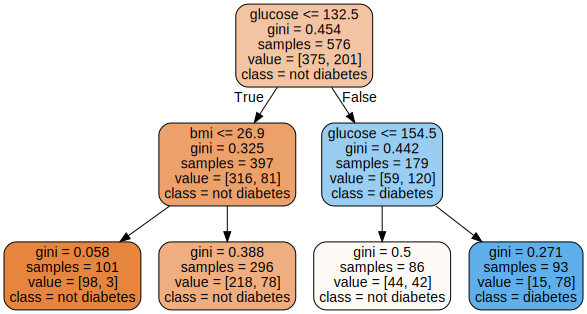

In [19]:
display(SVG(graph.pipe(format='svg')))

*Run the below cell if you couldn't get the above plot to work:*

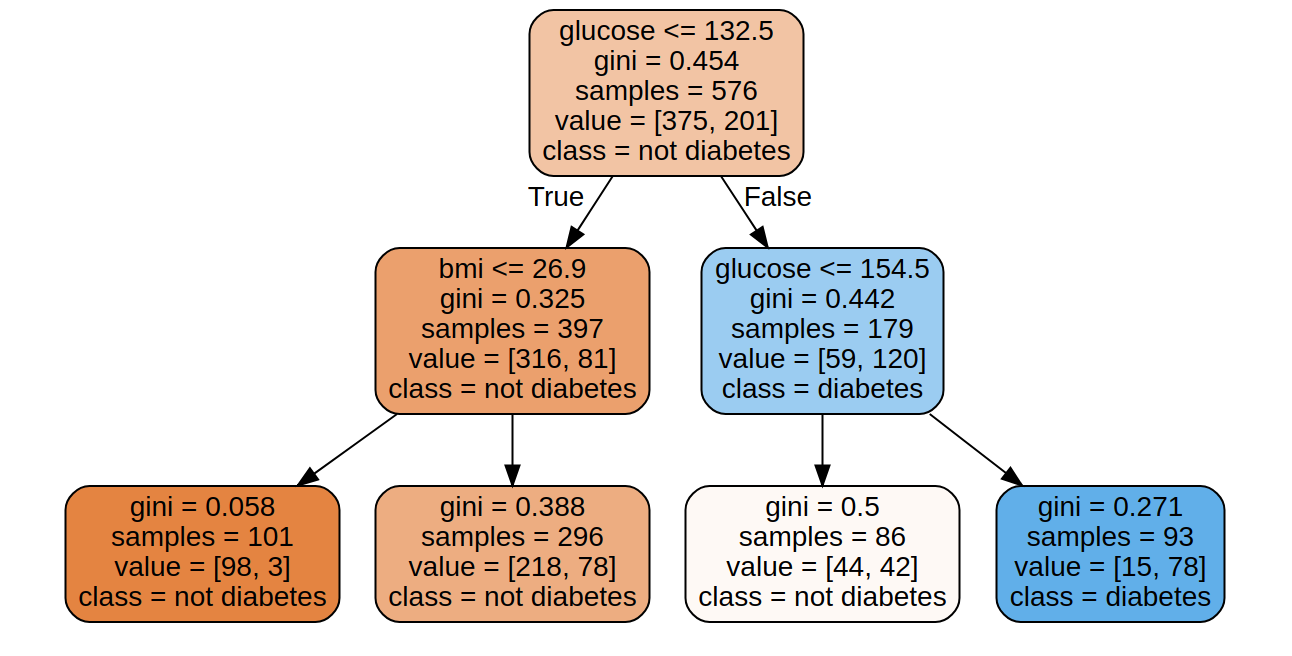

In [30]:
import IPython
IPython.display.Image("assets/decision_tree_diabetes.png", width='90%')

We see that we get something that can be used to make predictions. If you're tasked with diagnosing diabetes or not diabetes for an instance based on this decision tree you do as follows:

- Start at the root node. If the glucose level is 132.5 or below, take the path on the left. Else take the path on the right.
- If you took the left path then you look at the BMI. 
    - If BMI is less than 26.9, take the next left path. You end at a **leaf node** (a node where you can't go further). Your prediction is then `class = not diabetes`. 
    - If the BMI is larger than 26.9, take the right path. You end at another leaf node, and make the prediction `class = not diabetes`.
- If you took the right path then you again look at the glucose.
    - If glucose is less than 154.5 you take the left path. You end up at a leaf node and make the prediction `class = not diabetes`
    - If glucose is larger than 154.5 you take the right path, end up at a leaf node, and make the prediction `class = diabetes`.

This is exactly how predictions are made if you run `tree_clf.predict`. Each instance is fed through the tree according to its features, until it hits a leaf node, where the class is assigned.

> What are the other terms listed inside the nodes? "Gini", "samples", "value", what do they mean?

> **Your turn!** 
- How accurate is our classifier on the test set?
- Try creating a decision tree with `max_depth=3` and interpret the resulting tree as we did above.

## Decision trees glossary

- **Root node**: The top-most node. No parent node. Where you start. Poses the first if-else question.


- **Internal node**: Has one parent node and two children. These nodes pose if-else questions.


- **Leaf node**: A node without children. Not possible to go any further. A bottom node. These nodes provide predictions.


- **`samples`**: The number of training samples that the node applies to. The number of training instances that end up passing through the node. E.g. there are 179 samples for which the glucose is less than 154.5


- **`value`**: A list of the number of samples *of each class* that the node applies to. 


- **`gini`**: A measure of "impurity". The gini is 0 if all the training samples in that node belongs to a single class. It grows towards 1 as the class diversity at the node increases. 

We'll have more to say about the Gini impurity shortly.

But first, it's instructive to visualize the decision boundary produced by our decision tree, as we did in Part 3:

## Decision boundaries for decision trees

In [21]:
from matplotlib.colors import ListedColormap

In [22]:
# Modified from Geron

def plot_decision_boundary(clf, X, y, legend=False, plot_training=True):
        
    # Convert to numpy arrays in case X and y are data frames
    X, y = np.array(X), np.array(y)

    x1 = X[:,0] # First feature
    x2 = X[:, 1] # Second feature
    
    
    x1s = np.linspace(np.min(x1)-0.1*np.mean(x1), 1.1*np.max(x1), 100)
    x2s = np.linspace(np.min(x2)-0.1*np.mean(x2), 1.1*np.max(x2), 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    dots = ["yo", "bs", "g^"]
    
    if plot_training:
        for i in np.unique(y):
            
            plt.plot(X[:, 0][y==i], X[:, 1][y==i], dots[i], label=str(i))
    
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.legend(loc="lower right", fontsize=14)
    plt.title("Decision boundary")

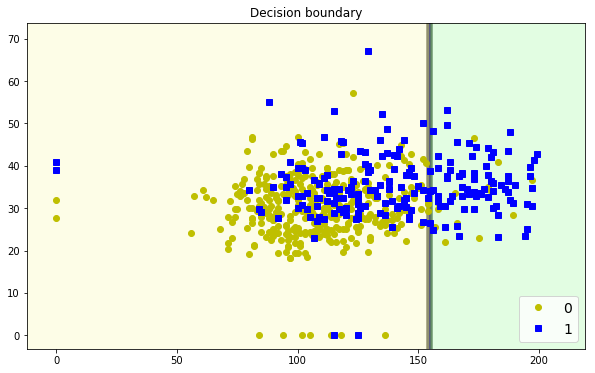

In [23]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(tree_clf, X_train,y_train)

Let's plot the decision boundary for a tree with `max_depth=3`:

In [24]:
tree_clf_d3 = DecisionTreeClassifier(max_depth=3, random_state=seed)

In [25]:
tree_clf_d3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

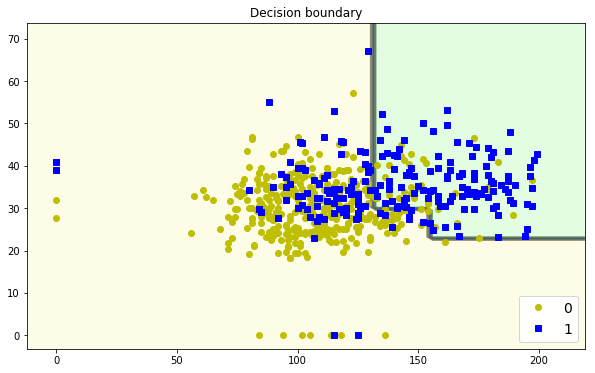

In [26]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(tree_clf_d3, X_train,y_train)

Note that the boundary is **not linear**. It is not a straight line, as it was for linear regression, and not smooth as for polynomial regression.

> **Your turn!** 
- Create a function that plots the decision boundary for a classifier with a specified `max_depth`. Note that the decision boundary gets more complex as you increase `max_depth`. That should make us think of overfitting...
- Compute the decision boundary for a different pair of features. That is, not (`glucose`, `bmi`), but something else.

## Gini and *information gain*

Decision trees learn the relationship between the training data and the corresponding labels by organizing the training data in a binary tree. Each leaf in the tree makes a specific prediction. Each internal node compares a single feature value agains a single threshold, and places instances in their corresponding child nodes. 

Training a decision tree is done recursively, roughly as follows (we'll study training more carefully below): The goal is to obtain leaves that are as pure as possible, with the maximum amount of samples belonging to the same class. Starting at the root node, the data is split into two parts based on the feature that has the larges **information gain**. This is repeated for each child of the node, and so on in an iterative way.


To achieve this we need a measure of information gain, and we also need it to tell us when a node is pure.

**Gini impurity** is one such measure:

$$G_i = 1 - \sum_{k=1}^n p_{i,k}^2 $$

Here $p_{i,k}$ is the proportion of the samples that belongs to class $k$ for the node $i$. 

We note that:
- If the node is **pure**, that is all the samples belong to a single class, then $G_i$ = 0. 
- If a node has many samples belonging to each of many classes, then $G_i$ gets closer to 1. Very impure.
- The **information gain** of a node can be computed as the Gini impurity minus the sum of the Gini impurity of its children weighted by their sizes. 

Let's try out the formula for the tree we found above:

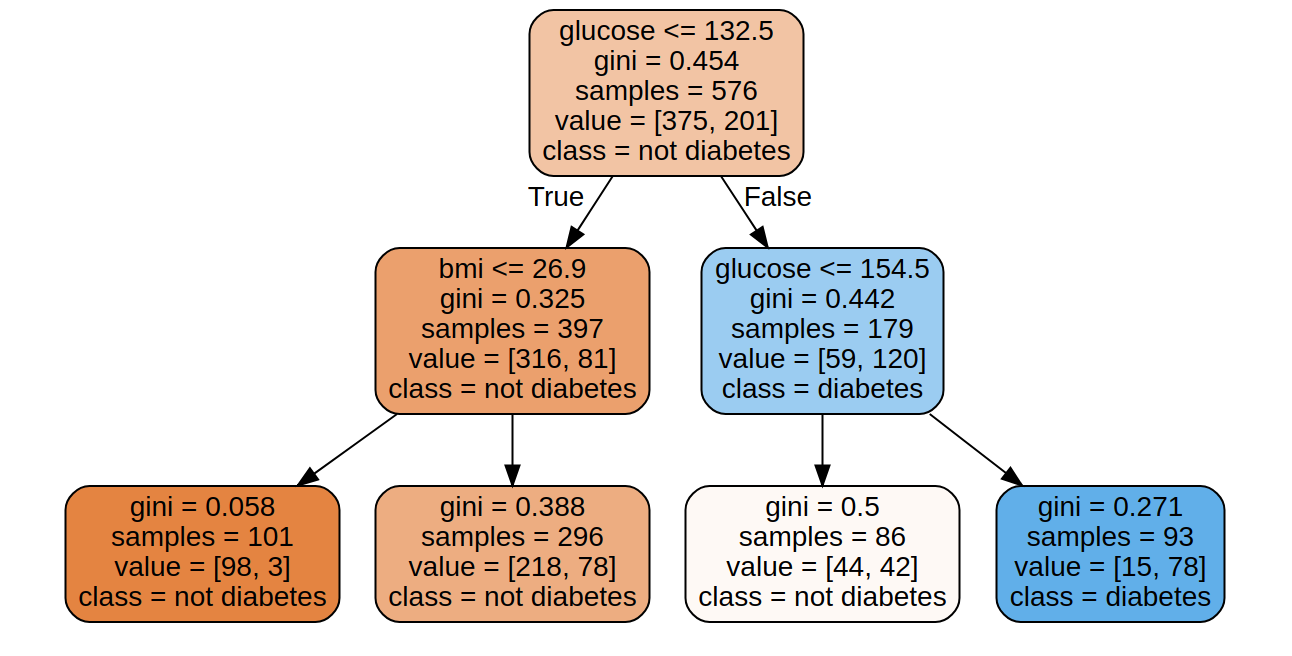

In [27]:
import IPython
IPython.display.Image("assets/decision_tree_diabetes.png", width='90%')

At the left child of the root node there are 397 samples, 316 beloning to not diabetes, 81 to diabets. 

The formula for $G$ gives:

$$G_i = 1 - \left(\left(\frac{316}{397}\right)^2 + \left(\frac{81}{397}\right)^2\right),$$
which is

In [28]:
1 - ((316/397)**2 + (81/397)**2)

0.32480378658579134

...which fits with what scikit-learn found for this tree.

The information gain at this node with respect to the feature BMI is the Gini impurity at the node minus the Gini impurities of its children, weighted by their relative sizes:

$$0.325 - \bigg(\left(\frac{101}{397}\right)\cdot 0.058 + \left(\frac{296}{397}\right)\cdot 0.388\bigg)$$

which is

In [29]:
0.325-((101/397) * 0.058 + (296/397) * 0.388)

0.020954659949622145

We can read this as: 
> "if we split the node on the feature BMI, then the information gained is 0.021". 

We want to split nodes in a way that gives very high information gain, because that would mean very pure children. This leads us to how decision trees are trained, studied next.

> **Your turn!** Calculate the Gini impurity for the second node in the bottom row (the second leaf).

# Growing decision trees: The CART algorithm for classification

Decision trees are constructed (that is, trained) using an algorithm that depends on information gain. 

The CART algorithm is one way to grow trees (others are ID3, C4.5 and C5.0): 

Starting at the root node, the algorithm searches *greedily* for a feature and a threshold (i.e. glucose and glucose less than 132.5) that gives the **highest information gain** when used to split the data. 

Once it has split the training data in two at the root, it continues in the same way on each of the two subsets. 

## Cost function

In other words, if we write $f$ for feature and $t_k$ for threshold, the cost function that CART tries to minimize is **the node impurity**:

$$J(f, t_k) = \frac{m_{\mbox{left}}}{m} G_{\mbox{left}} + \frac{m_{\mbox{right}}}{m} G_{\mbox{right}}, $$

where $m$ is the total number of samples in the node and $m_{\mbox{left}}$, $m_{\mbox{right}}$ the number of samples in the left and right child. 

The algorithm stops once it reaches the `max_depth`, or if it's not possible to find more splits that reduce the impurity. Or when another stopping criterium, for minimum number of samples in a node, is reached. 

<center><span style="font-size:200%; color: red">More content will be added</span></center>

# Regularization: preventing overfitting

# Regression

# Instability. The downsides of using decision trees..

# Extra

> **Your turn!**
- Train a decision tree classifier on the breast cancer wisconsin dataset (`sklearn.datasets.load_breast_cancer`), with `max-depth` set to 3 or 4.
- Test it on a test set (which one's better, `max_depth` 3 or 4?)
- Plot the decision tree.


**Extra resources:**
> Scikit-learns documentation for decision trees is very useful. You should have a look: http://scikit-learn.org/stable/modules/tree.html.

> `dtreeeviz` is a nice library for visualizing decision trees: http://explained.ai/decision-tree-viz